In [1]:
import matplotlib.pyplot as plt
import neurokit2 as nk
from math import isnan
import pandas as pd
import numpy as np
import h5py
import ast

In [2]:
sample_freq = 500   # Hz

metadata_full = pd.read_csv('metadata.csv')
metadata = metadata_full.head(200)
metadata = metadata.drop(columns=['Date', 'Patient_ID'])
metadata['Age'].astype(np.int32)
metadata['N'].astype(np.int32)
health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
health_ECG_ID = health_metadata['ECG_ID'].values

ecg_signals = []

for i in health_ECG_ID:
    number = int(i[1:])

    record_num = (number - 1) // 5000
    if record_num > 4:
        record_num = 4
    record_num = record_num + 1
    
    with h5py.File(f'records/record{record_num}/{i}.h5', 'r') as f:
        ecg_signals.append(f['ecg'][()])

In [5]:
health_metadata

,ECG_ID,AHA_Code,Age,Sex,N
1,A00002,1,32,M,6000
2,A00003,1,63,M,6500
5,A00006,1,46,F,5000
7,A00008,1,32,M,5000
8,A00009,1,48,F,6000
...,...,...,...,...,...
185,A00186,1,43,F,5000
187,A00188,1,43,F,5000
191,A00192,1,42,M,6000
198,A00199,1,65,M,5000


In [ ]:
def int_nan(i):
    if isnan(float(i)):
        return -1
    else:
        return int(i)

def extract_PQRST(ids, ecg_signals):
    annotations = []

    for idx, (ecg_id, signal) in enumerate(zip(ids, ecg_signals)):
        record_annotations = {
            'id': ecg_id,
        }

        for channel in range(12):
            channel_signal = signal[channel, :]
            try:
                signals, info = nk.ecg_process(channel_signal, sampling_rate=sample_freq)

                record_annotations[f'channel_{channel}_P'] = [int_nan(i) for i in list(info['ECG_P_Peaks'])] if isinstance(info['ECG_P_Peaks'], (np.ndarray, list)) else []
                record_annotations[f'channel_{channel}_QRS'] = [int_nan(i) for i in list(info['ECG_R_Peaks'])] if isinstance(info['ECG_R_Peaks'], (np.ndarray, list)) else []
                record_annotations[f'channel_{channel}_T'] = [int_nan(i) for i in list(info['ECG_T_Peaks'])] if isinstance(info['ECG_T_Peaks'], (np.ndarray, list)) else []
                record_annotations[f'channel_{channel}_RR'] = [int_nan(i) for i in list(np.diff(info['ECG_R_Peaks']))] if isinstance(info['ECG_R_Peaks'], (np.ndarray, list)) else []

            except Exception as e:
                print(f"Ошибка при обработке записи {ecg_id}, канал {channel}: {e}")

        annotations.append(record_annotations)

    df = pd.DataFrame(annotations)
    df.to_csv('ecg_annotations.csv', index=False)

def visualize_PQRST_pandas(df, sampling_rate=500, clear=0, record_index=0, alpha=0.2):
    # Использование clear меняет амплитуды, что для анализа нормы не подходит
    # (только если не нормировать, но с фильром Баттерворта нормирование неточное)

    ecg_order = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    record = df.iloc[record_index]
    id_record = record['id']

    number = int(id_record[1:])

    record_num = (number - 1) // 5000
    if record_num > 4:
        record_num = 4
    record_num = record_num + 1

    with h5py.File(f'./records/record{record_num}/{id_record}.h5', 'r') as f:
        ecg_signals = f['ecg'][()]

    fig, axes = plt.subplots(12, 1, figsize=(12, 24))

    for channel_index in range(12):
        if clear:
            channel_signal = nk.ecg_clean(ecg_signals[channel_index, :], sampling_rate=500)
        else:
            channel_signal = ecg_signals[channel_index, :]

        def safe_literal_eval(value):
            if isinstance(value, str) and 'nan' in value:
                value = value.replace('nan', '[]')
            
            if not isinstance(value, str) and isnan(value):
                return []
            return ast.literal_eval(value) if value else []

        p_peaks = safe_literal_eval(record[f'channel_{channel_index}_P'])
        qrs_peaks = safe_literal_eval(record[f'channel_{channel_index}_QRS'])
        t_peaks = safe_literal_eval(record[f'channel_{channel_index}_T'])

        t_peaks = [peak for peak in t_peaks if isinstance(peak, (int, float, np.number))]

        axes[channel_index].plot(channel_signal, label='ЭКГ сигнал')
        axes[channel_index].plot(p_peaks, channel_signal[p_peaks], 'go', label='P-волны', alpha=alpha)
        axes[channel_index].plot(qrs_peaks, channel_signal[qrs_peaks], 'ro', label='QRS-комплекс', alpha=alpha)
        axes[channel_index].plot(t_peaks, channel_signal[t_peaks], 'bo', label='T-волны', alpha=alpha)

        axes[channel_index].set_title(f'Отведение {ecg_order[channel_index]}')
        axes[channel_index].set_xlabel('Время (отсчеты)')
        axes[channel_index].set_ylabel('Амплитуда')
        axes[channel_index].legend()
        axes[channel_index].grid()

    plt.tight_layout()
    plt.show()

In [150]:
extract_PQRST(health_ECG_ID, ecg_signals)

In [16]:
df = pd.read_csv('ecg_annotations.csv')


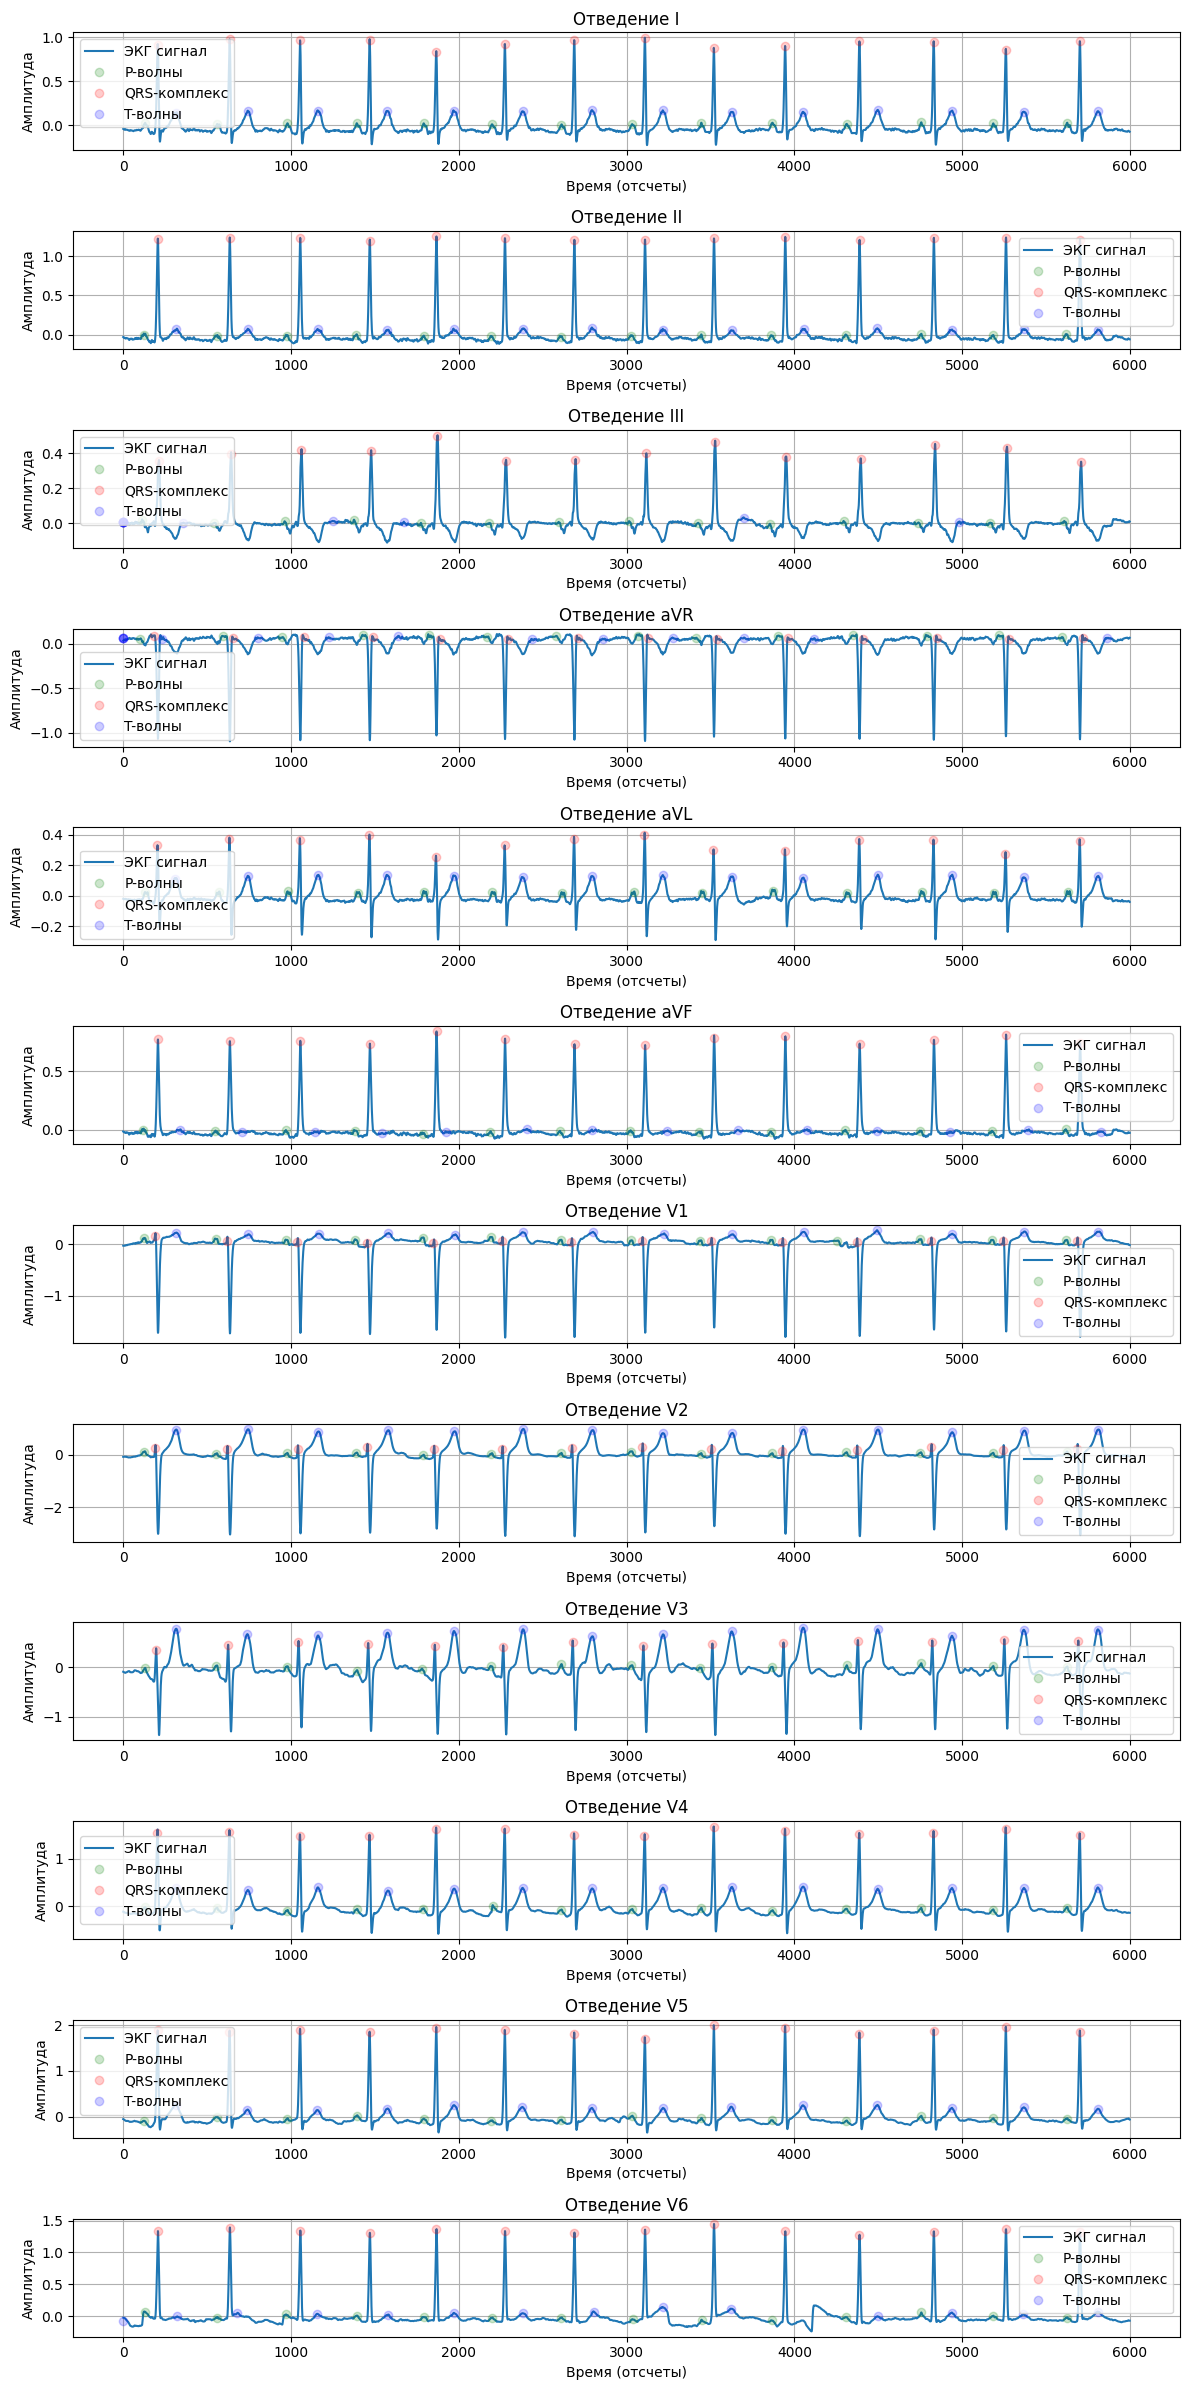

In [23]:
visualize_PQRST_pandas(df, 0, clear=0)

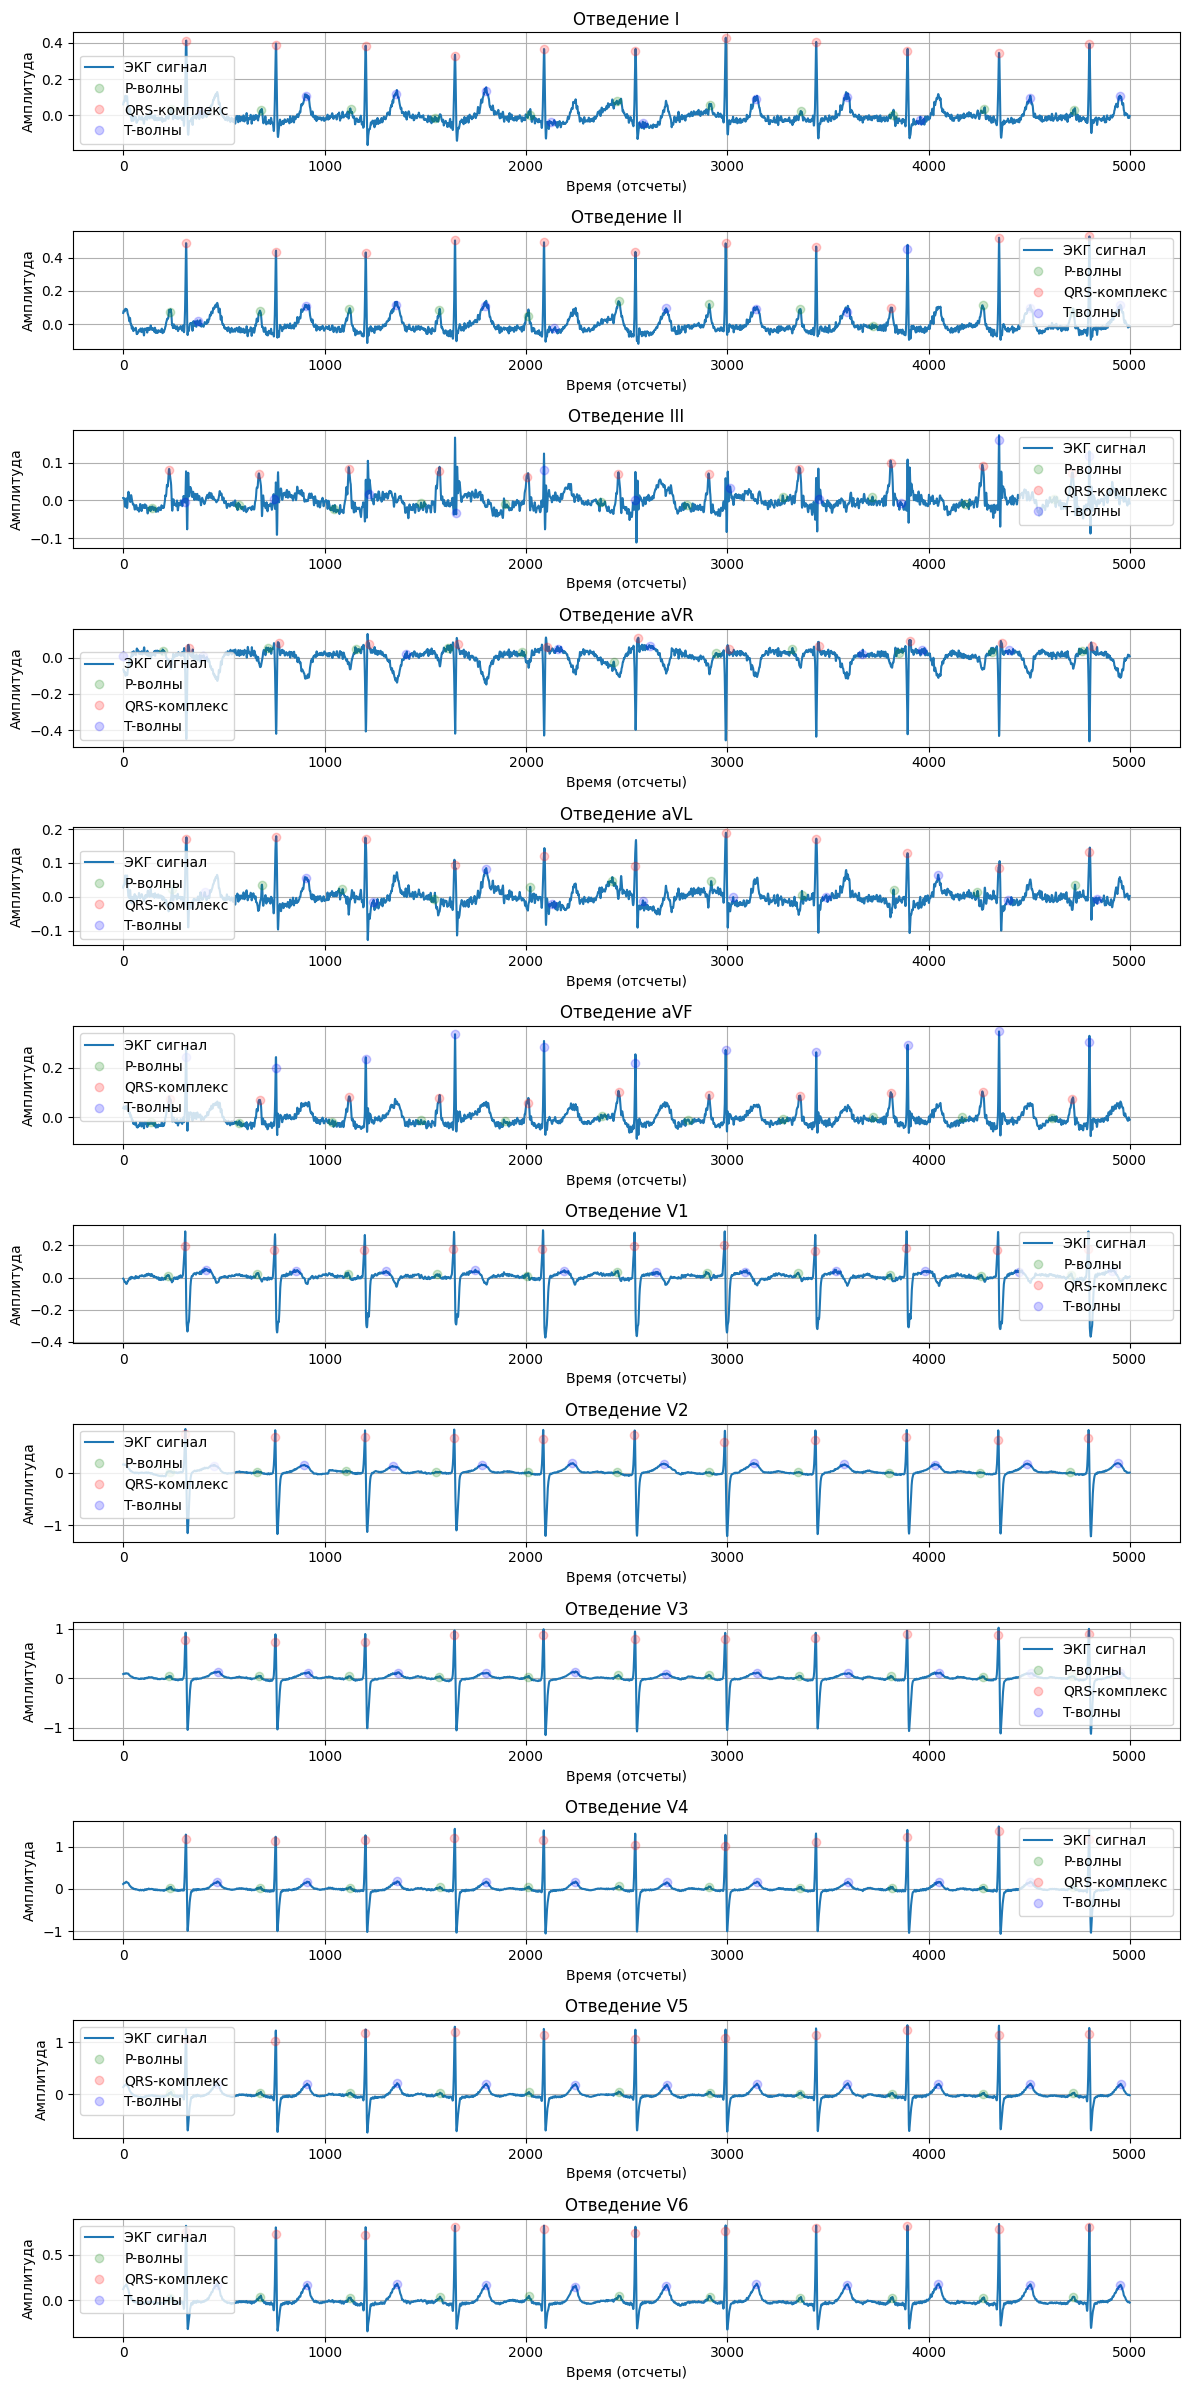

In [161]:
visualize_PQRST_pandas(df, 50)